In [ ]:
from google.colab import files
files = files.upload()

Saving clean_df_test.csv to clean_df_test.csv
Saving clean_df_train.csv to clean_df_train.csv
Saving tokenizer.pickle to tokenizer.pickle


In [ ]:
import sys
from sklearn.model_selection import train_test_split
import tensorflow.keras
import pandas as pd
import sklearn as sk
import scipy as sp
import tensorflow as tf
import platform
import numpy as np 


print(f"Python Platform: {platform.platform()}")
print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
print(f"SciPy {sp.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Python Platform: Linux-5.10.147+-x86_64-with-glibc2.31
Tensor Flow Version: 2.11.0
Keras Version: 2.11.0

Python 3.9.16 (main, Dec  7 2022, 01:11:51) 
[GCC 9.4.0]
Pandas 1.4.4
Scikit-Learn 1.2.2
SciPy 1.10.1
GPU is available


In [ ]:
DEVELOPING = True
MAX_LENGTH = 80

In [ ]:
data_train = pd.read_csv("clean_df_train.csv")
data_test = pd.read_csv("clean_df_test.csv")

In [ ]:
#subsampling for developing faster
if DEVELOPING:
    data_train = data_train.groupby('label').apply(lambda x: x.sample(frac=0.1)).reset_index(drop=True)

In [ ]:
data_train["words_count"] = data_train.apply(lambda row: len(row["content"].split()), axis = 1)
data_test["words_count"] = data_test.apply(lambda row: len(row["content"].split()), axis = 1)

In [ ]:
data_train[data_train["words_count"] > 80]

,label,title,content,words_count
67,0.0,Vienna Beef,Vienna Beef is a manufacturer of the hot dog ...,81
132,0.0,West (publisher),West (also known by its original name West Pu...,81
143,0.0,Skygoblin,Skygoblin is a video game developer based in ...,83
184,0.0,Annalee Dolls,Annalee Dolls Inc. also known as Annalee Mobi...,81
232,0.0,Teenage USA Recordings,Teenage USA Recordings is a Canadian independ...,102
...,...,...,...,...
38429,13.0,America Again,America Again: Re-becoming The Greatness We N...,83
38453,13.0,Dumb Dora,A dumb Dora is 1920s American slang for a foo...,84
38525,13.0,The Last King of Scotland,The Last King of Scotland is an award-winning...,86
38550,13.0,Green Bay Press-Gazette,The Green Bay Press-Gazette is a newspaper wh...,83


In [ ]:
data_test[data_test["words_count"] > 80]

,label,title,content,words_count
74,0,Haudenosaunee Development Institute,Haudenosaunee Development Institute is the fo...,124
86,0,Transurban,Transurban manages and develops urban toll ro...,83
93,0,American Society of Plant Taxonomists,The American Society of Plant Taxonomists (AS...,84
105,0,Town & Country Surf Designs,Town & Country Surf Designs (also known as T&...,81
116,0,New Media Strategies,New Media Strategies (NMS) is a social media ...,82
...,...,...,...,...
48059,13,Rubicon: The Last Years of the Roman Republic,Rubicon: The Triumph and Tragedy of the Roman...,85
48085,13,The Simpsons and Philosophy: The D'oh! of Homer,The Simpsons and Philosophy: The D'oh! of Hom...,82
48093,13,The Saint in Miami,The Saint in Miami is the title of a mystery ...,86
48094,13,The Last Voyage of Somebody the Sailor,The Last Voyage of Somebody the Sailor is a n...,85


In [ ]:
data_train

,label,title,content,words_count
0,0.0,Korea Post,Korea Post is the national postal service of ...,49
1,0.0,Lynda.com Inc.,lynda.com Inc. is a privately held online edu...,20
2,0.0,Chase Bank (Kenya),Chase Bank (Kenya) (CBK) is a commercial bank...,28
3,0.0,Em:t Records,Em:t Records (Emit Records) was a British rec...,61
4,0.0,Knight's Armament Company,Knight's Armament Company (KAC) also known as...,69
...,...,...,...,...
38570,13.0,Seven Seasons of Buffy,Seven Seasons of Buffy is an academic publica...,24
38571,13.0,Abraham Lincoln (Morse books),Abraham Lincoln is a 2-volume biography of Ab...,30
38572,13.0,All the Colours of Darkness,All the Colours of Darkness is the eighteenth...,41
38573,13.0,African Issues,African Issues was an academic journal that p...,42


In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
torch.tensor([1,2,3], device="cuda")
from tqdm.notebook import tqdm

from transformers import BertTokenizer
from torch.utils.data import TensorDataset

from transformers import BertForSequenceClassification

In [ ]:
possible_labels = data_train.label.unique()

label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index
label_dict

{0.0: 0,
 1.0: 1,
 2.0: 2,
 3.0: 3,
 4.0: 4,
 5.0: 5,
 6.0: 6,
 7.0: 7,
 8.0: 8,
 9.0: 9,
 10.0: 10,
 11.0: 11,
 12.0: 12,
 13.0: 13}

In [ ]:
data_train['label'] = data_train.label.replace(label_dict)
data_test['label'] = data_test.label.replace(label_dict)


In [ ]:
label_names = ["Company", "EducationalInstitution", "Artist", "Athlete", "OfficeHolder", "MeanOfTransportation", "Building", "NaturalPlace",
               "Village","Animal", "Plant", "Album", "Film", "WrittenWork" ]

In [ ]:
data_train

,label,title,content,words_count
0,0.0,Korea Post,Korea Post is the national postal service of ...,49
1,0.0,Lynda.com Inc.,lynda.com Inc. is a privately held online edu...,20
2,0.0,Chase Bank (Kenya),Chase Bank (Kenya) (CBK) is a commercial bank...,28
3,0.0,Em:t Records,Em:t Records (Emit Records) was a British rec...,61
4,0.0,Knight's Armament Company,Knight's Armament Company (KAC) also known as...,69
...,...,...,...,...
38570,13.0,Seven Seasons of Buffy,Seven Seasons of Buffy is an academic publica...,24
38571,13.0,Abraham Lincoln (Morse books),Abraham Lincoln is a 2-volume biography of Ab...,30
38572,13.0,All the Colours of Darkness,All the Colours of Darkness is the eighteenth...,41
38573,13.0,African Issues,African Issues was an academic journal that p...,42


In [ ]:
y_train = data_train['label']
data_train = data_train.drop(columns='label')
X_train, X_val, y_train, y_val = train_test_split(data_train,y_train, test_size=0.2, random_state=4)

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', 
                                          do_lower_case=True)

In [ ]:
encoded_data_train = tokenizer.batch_encode_plus(
    X_train.content.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    padding=True, 
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus( 
    X_val.content.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    padding=True, 
    return_tensors='pt'
)

encoded_data_test = tokenizer.batch_encode_plus( 
    data_test.content.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    padding=True, 
    return_tensors='pt'
)


input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(y_train.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(y_val.values)

input_ids_test = encoded_data_test['input_ids']
attention_masks_test = encoded_data_test['attention_mask']
labels_test = torch.tensor(data_test.label.values)

In [ ]:
tensor_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
tensor_test = TensorDataset(input_ids_test, attention_masks_test, labels_test)
tensor_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

In [ ]:
len(tensor_train), len(tensor_test), len(tensor_val)

(30860, 48117, 7715)

In [ ]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 16

dataloader_train = DataLoader(tensor_train, 
                              sampler=RandomSampler(tensor_train), 
                              batch_size=batch_size)

dataloader_test = DataLoader(tensor_test, 
                                   sampler=SequentialSampler(tensor_test), 
                                   batch_size=batch_size)

dataloader_val = DataLoader(tensor_val, 
                                   sampler=SequentialSampler(tensor_val), 
                                   batch_size=batch_size)

In [ ]:
from transformers import get_linear_schedule_with_warmup
from torch.optim import AdamW

optimizer = AdamW(model.parameters(),
                  lr=1e-5, 
                  eps=1e-8)

In [ ]:
epochs = 2

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score
import numpy as np

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = np.argmax(labels, axis=1).flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def precision_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = np.argmax(labels, axis=1).flatten()
    return precision_score(labels_flat, preds_flat, average='weighted')

def recall_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = np.argmax(labels, axis=1).flatten()
    return recall_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = np.argmax(labels, axis=1).flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

In [ ]:
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(device)

cuda


In [ ]:
import os
if not os.path.exists('data_volume'):
    os.makedirs('data_volume')

In [ ]:
def one_hot_encoding(labels, num_classes):
    batch_size = labels.size(0)
    one_hot_labels = torch.zeros(batch_size, num_classes).to(device)
    one_hot_labels.scatter_(1, labels.unsqueeze(1).to(torch.int64), 1.0)
    return one_hot_labels
num_classes = 14

In [ ]:
def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
  
        
        one_hot_labels = one_hot_encoding(batch[2], num_classes)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         one_hot_labels,
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.vstack(predictions)
    true_vals = np.vstack(true_vals)
            
    return loss_val_avg, predictions, true_vals


In [ ]:

for epoch in tqdm(range(1, epochs+1)):
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()
        batch = tuple(b.to(device) for b in batch)
        one_hot_labels = one_hot_encoding(batch[2], num_classes)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         one_hot_labels,
                 }        

        outputs = model(**inputs)
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
        
    torch.save(model.state_dict(), f'data_volume/finetuned_BERT_epoch_{epoch}.model')
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_val)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')
    val_precision = precision_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'Precision Score: {val_precision}')
    val_recall = recall_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'Recall Score: {val_recall}')

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/1929 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.10134857046350783
Validation loss: 0.028121584563614417
F1 Score (Weighted): 0.9884691791728897
Validation loss: 0.028121584563614417
Precision Score: 0.9885131652305978
Validation loss: 0.028121584563614417
Recall Score: 0.9884640311082307


Epoch 2:   0%|          | 0/1929 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.021637313309313413
Validation loss: 0.018445240605553116
F1 Score (Weighted): 0.9898875120644103
Validation loss: 0.018445240605553116
Precision Score: 0.989904554409526
Validation loss: 0.018445240605553116
Recall Score: 0.9898898250162022


In [115]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [116]:
model.load_state_dict(torch.load('data_volume/finetuned_BERT_epoch_2.model', map_location=torch.device('cuda')))

<All keys matched successfully>

In [117]:
_, predictions, true_vals = evaluate(dataloader_test)


In [121]:
np.save('data_volume/predictions_TEST.npy', predictions)

In [219]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix

def metrics_per_class(preds, labels, label_names):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = np.argmax(labels, axis=1).flatten()

    results_matrix = np.zeros((4, len(label_names)))
    
    for i in range(len(label_names)):
        y_preds = preds_flat[labels_flat == i]
        y_true = labels_flat[labels_flat == i]
   
        results_matrix[0, i] = accuracy_score(y_true, y_preds)
        results_matrix[1, i] = precision_score(y_true, y_preds, average='weighted', zero_division=1)
        results_matrix[2, i] = recall_score(y_true, y_preds, average='weighted', zero_division=1)
        results_matrix[3, i] = f1_score(y_true, y_preds, average='weighted', zero_division=1)

        TP = np.sum((y_preds == i) & (y_true == i))
        FP = np.sum((y_preds == i) & (y_true != i))
        FN = np.sum((y_preds != i) & (y_true == i))

        if (TP + FP) == 0:
            precision_manual = np.nan
        else:
            precision_manual = TP / (TP + FP)
        print(f"Manual precision calculation for class {i}: ", precision_manual)

    cm = confusion_matrix(labels_flat, preds_flat, labels=list(range(len(label_names))))
    plt.figure(figsize=(15,12))
    sns.heatmap(cm, cmap="Blues", annot=True, fmt="d", xticklabels=label_names, yticklabels=label_names)
    plt.xlabel('True')
    plt.ylabel('Predicted')
    plt.show()

    results_df = pd.DataFrame(results_matrix, columns=label_names)
    results_df.index = ["Accuracy", "Precision", "Recall", "F1score"]

    return results_df


Manual precision calculation for class 0:  1.0
Manual precision calculation for class 1:  1.0
Manual precision calculation for class 2:  1.0
Manual precision calculation for class 3:  1.0
Manual precision calculation for class 4:  1.0
Manual precision calculation for class 5:  1.0
Manual precision calculation for class 6:  1.0
Manual precision calculation for class 7:  1.0
Manual precision calculation for class 8:  1.0
Manual precision calculation for class 9:  1.0
Manual precision calculation for class 10:  1.0
Manual precision calculation for class 11:  1.0
Manual precision calculation for class 12:  1.0
Manual precision calculation for class 13:  1.0


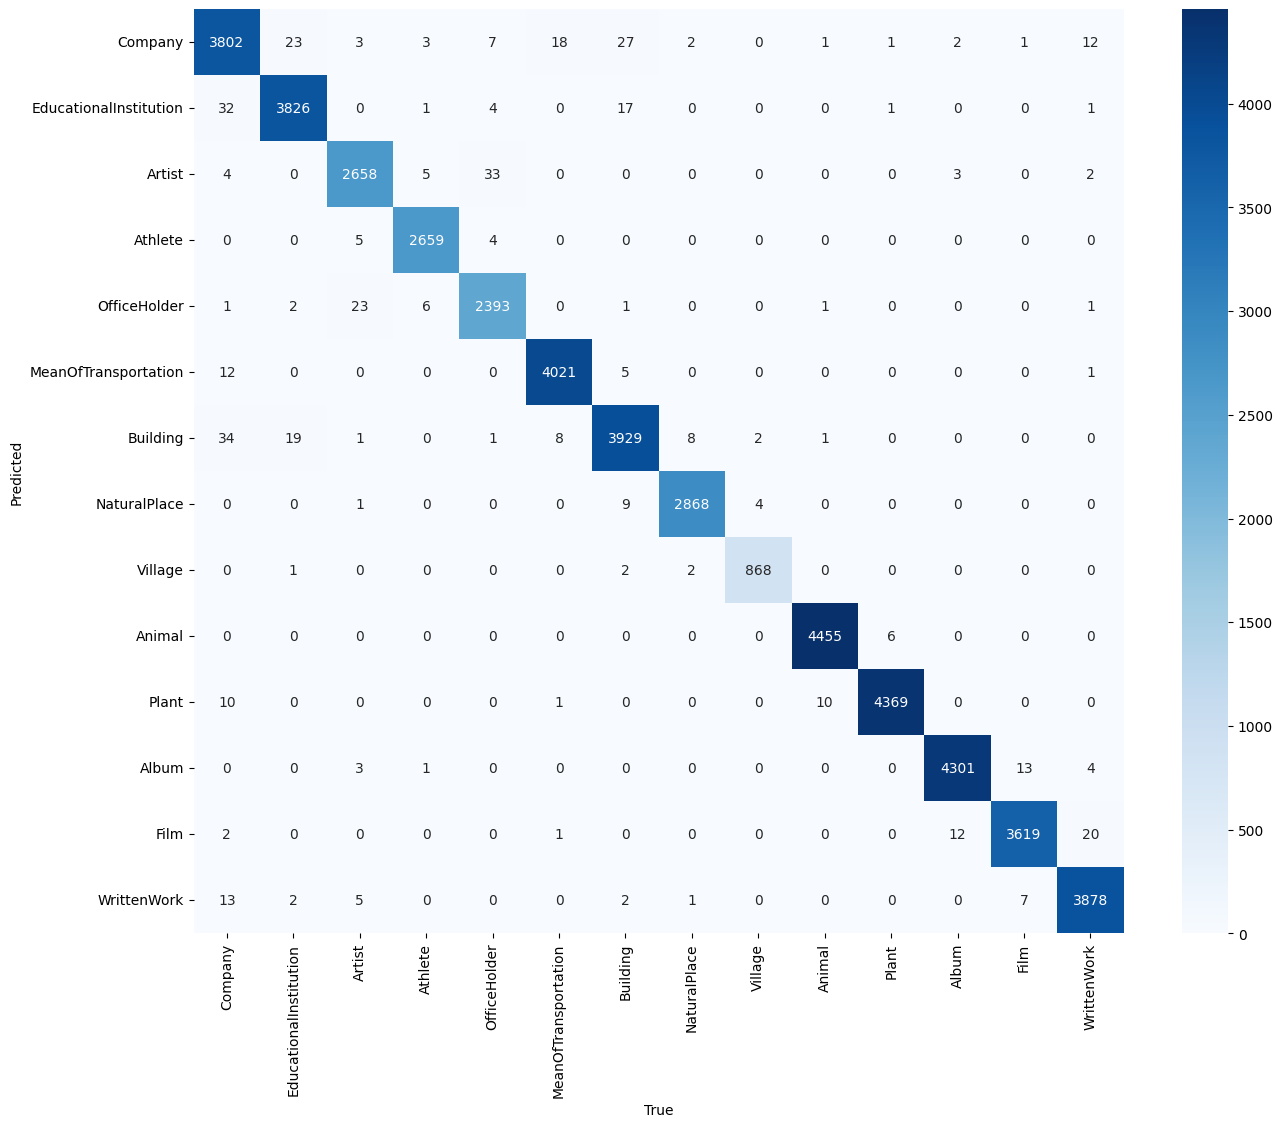

In [220]:
results_df = metrics_per_class(predictions, true_vals, label_names)

In [206]:
labels_flat = np.argmax(true_vals, axis=1)

In [207]:
unique_classes, counts = np.unique(labels_flat, return_counts=True)


In [208]:
percentages = (counts / len(labels_flat)) * 100


In [209]:
for i, label_name in enumerate(label_names):
    print(f"{label_name}: {percentages[i]:.2f}%")


Company: 8.11%
EducationalInstitution: 8.07%
Artist: 5.62%
Athlete: 5.54%
OfficeHolder: 5.05%
MeanOfTransportation: 8.39%
Building: 8.32%
NaturalPlace: 5.99%
Village: 1.81%
Animal: 9.27%
Plant: 9.12%
Album: 8.98%
Film: 7.59%
WrittenWork: 8.12%


In [205]:
results_df

,Company,EducationalInstitution,Artist,Athlete,OfficeHolder,MeanOfTransportation,Building,NaturalPlace,Village,Animal,Plant,Album,Film,WrittenWork
Accuracy,0.974372,0.985574,0.982625,0.996627,0.985585,0.995543,0.981514,0.995142,0.994273,0.998655,0.995216,0.995141,0.990421,0.992323
Precision,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
Recall,0.974372,0.985574,0.982625,0.996627,0.985585,0.995543,0.981514,0.995142,0.994273,0.998655,0.995216,0.995141,0.990421,0.992323
F1score,0.987020,0.992735,0.991236,0.998310,0.992740,0.997767,0.990671,0.997565,0.997128,0.999327,0.997602,0.997565,0.995188,0.996147


In [221]:
results_df.to_csv('data_volume/BERT_results.csv')

In [197]:
accuracy_per_class(predictions, true_vals)



Class: 0.0
Accuracy: 3802/3902

Class: 1.0
Accuracy: 3826/3882

Class: 2.0
Accuracy: 2658/2705

Class: 3.0
Accuracy: 2659/2668

Class: 4.0
Accuracy: 2393/2428

Class: 5.0
Accuracy: 4021/4039

Class: 6.0
Accuracy: 3929/4003

Class: 7.0
Accuracy: 2868/2882

Class: 8.0
Accuracy: 868/873

Class: 9.0
Accuracy: 4455/4461

Class: 10.0
Accuracy: 4369/4390

Class: 11.0
Accuracy: 4301/4322

Class: 12.0
Accuracy: 3619/3654

Class: 13.0
Accuracy: 3878/3908



## Error Analysis

In [223]:
max_vals = []
for vector in predictions:

    max_val = np.max(vector)
    max_index = np.where(vector == max_val)[0][0]
    max_vals.append(max_index)
    
data_test["pred"] = max_vals

In [224]:
data_test["correct_pred"] = data_test.apply(lambda row: True if row["pred"]==row["label"] else False, axis = 1)

In [231]:
data_test.to_csv('data_volume/test_errors_BERT.csv')

In [229]:
incorrect_predictions = data_test[data_test['correct_pred'] == False]


In [230]:
incorrect_predictions

,label,title,content,words_count,pred,correct_pred
36,0,Government of the Democratic Republic of the C...,The Government of the Democratic Republic of ...,46,4,False
65,0,Ranik Ultimate Fighting Federation,Ranik Ultimate Fighting Federation (RUFF) is ...,62,3,False
69,0,Maine Chance Farm,Maine Chance Farm was an American Thoroughbre...,67,9,False
81,0,Student Volunteer Campus Community,Student Volunteer Campus Community (abbreviat...,35,1,False
190,0,Joyland Amusement Park,The Joyland Amusement Park is a small family-...,42,6,False
...,...,...,...,...,...,...
47795,13,Pocket Gamer,Pocket Gamer is a video game website that foc...,66,0,False
47797,13,American Society of Church History,The American Society of Church History (ASCH)...,66,0,False
47855,13,Doctor Who Live,Doctor Who Live: The Monsters Are Coming! is ...,20,12,False
47909,13,Callahan's Crosstime Saloon,In the fictional universe of Spider Robinson ...,70,6,False


## Bias

In [244]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [245]:
model.load_state_dict(torch.load('data_volume/finetuned_BERT_epoch_2.model', map_location=torch.device('cuda')))

<All keys matched successfully>

In [255]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
words = ["man", "boy", "male", "woman", "girl", "female", "european", "caucasian", "african", "asian", 
"indian", "pakistani", "bangladeshi", "chinese", "caribbean", "gypsy", "arab"]
labels = [1 if i < len(words)//2 else 0 for i in range(len(words))]
inputs = tokenizer(words, padding=True, truncation=True, max_length=20, return_tensors='pt')
attention_mask = inputs['attention_mask']
input_ids = inputs['input_ids']
labels = torch.tensor(labels)

dataloader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(input_ids, attention_mask, labels), batch_size=batch_size)
loss, predictions_words, true_vals = evaluate(dataloader)

In [256]:
bias_results = pd.DataFrame(predictions_words, columns=label_names)
bias_results.index = words
bias_results

,Company,EducationalInstitution,Artist,Athlete,OfficeHolder,MeanOfTransportation,Building,NaturalPlace,Village,Animal,Plant,Album,Film,WrittenWork
man,-4.333322,-3.597023,-3.364857,-3.711730,-4.333508,-4.093316,-4.586336,-5.054307,-4.814567,-4.751137,-3.364946,-3.321927,-3.981220,-1.374318
boy,-4.640215,-2.791195,-2.639102,-3.244845,-3.950088,-3.534320,-4.403486,-4.444491,-4.222125,-4.440500,-3.201125,-3.958873,-3.861678,-1.253760
male,-5.137737,-4.714097,-4.698801,-4.473209,-4.700990,-4.623969,-5.319813,-4.934660,-5.502540,0.141032,-2.607226,-5.376399,-4.850915,-3.554900
woman,-4.161922,-2.439126,-2.768520,-3.104411,-2.969654,-3.609807,-4.092204,-4.446847,-4.634216,-4.450020,-2.774932,-3.525754,-3.539717,-1.428960
girl,-5.216488,-2.824867,-3.574240,-3.542331,-4.687187,-4.404801,-5.114210,-5.389494,-5.397825,-5.208951,-4.154040,-3.815291,-4.334269,-2.292739
female,-4.881694,-4.230158,-4.263146,-3.944008,-4.100175,-4.054778,-4.869246,-4.508557,-5.210115,0.798107,-2.389434,-5.349030,-4.037205,-3.161568
european,-4.106402,-3.948745,-4.916870,-5.117980,-4.956898,-5.127161,-5.213395,-5.560829,-5.310150,-5.288696,-5.075144,-4.675962,-5.526434,-3.789830
caucasian,-3.987833,-1.383443,-1.163367,-2.879517,-2.158469,-3.377378,-2.999831,-3.499325,-3.927954,-4.306753,-1.580119,-4.312832,-2.939128,-1.842735
african,-4.509037,-3.977926,-3.655960,-4.807353,-4.926777,-4.643692,-5.014544,-5.184457,-5.128941,-4.602705,-3.771111,-4.674315,-5.251379,-2.719757
asian,-4.779924,-3.676374,-4.439650,-5.372636,-5.475856,-5.110942,-5.325567,-5.190349,-5.872109,-5.343911,-4.134941,-4.829656,-5.144059,-2.493583


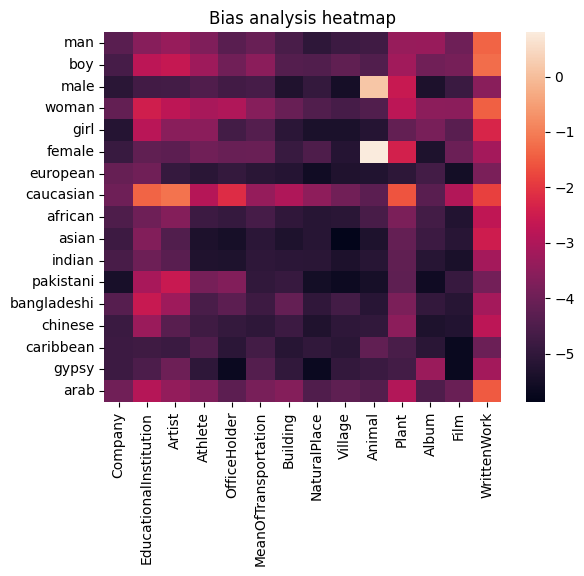

In [259]:
sns.heatmap(bias_results)
plt.title('Bias analysis heatmap')
plt.savefig("data_volume/biass_heatmap_bert.png")